# Single AI crypto concept

In [1]:
from xdata_config import *

WINDOW:30 - BUY_PCT:1.5 MAX_FORCAST_SIZE:30 - BUY_MODE:IS_GOOD 


## 1 - Imports and fonctions

In [4]:
from functions_module import *

WINDOW:240 - BUY_PCT:4.5 MAX_FORCAST_SIZE:240 - BUY_MODE:IS_GOOD 


2023-04-30 02:53:34.688783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-30 02:53:34.688966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-30 02:53:34.949426: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-30 02:53:39.866700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-30 02:53:39.867417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

Memory usage: 3897.91 MB


In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
from keras.layers import BatchNormalization, Dense

In [4]:
def buy_optimal_5m(df,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=MAX_FORCAST_SIZE):
    #df = df.fillna(0)
    mino = BUY_PCT / 100.0
    maxo = SELL_PCT / 100.0
    window=max(7,int(window/5))
    max_forecast_size=window#MAX_FORCAST_SIZE
    try:
        after_dip_val=AFTER_MARK
    except:
        after_dip_val=3
    print(f"after mark = : {after_dip_val}")
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {BUY_PCT}% of the current price ")
    except:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")
        
    rolling_max_close_diff = ((df['close-1_5min'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)
    
    # Compute rolling minimum values
    window_list=[window]#[3, 5, 7, 10, 15, 20]
    
    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close-1_5min'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low-1_5min'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)

    
    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df



def full_expand_costum(df1m,df5m,df15m,df1h,df1d,w1m=10,w5m=30,w15m=30,w1h=3,w1d=7):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=w1m).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,w1d)
    d1min=rapid1h_expand(d1min,df1h,w1h)
    d1min=rapid15m_expand(d1min,df15m,w15m)
    d1min=rapid5m_expand(d1min,df5m,w5m)
    return d1min

def maxi_expand(pair="GMT/USDT", i=0, j=10000, window=2, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase,w1m=6,w5m=30,w15m=30,w1h=3,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=30,btc_w1d=30):
    start_index=i
    end_index=j
    window_size=window
    buy_fn=buy_function
    """
    This function takes in several parameters to calculate technical indicators and returns a merged dataframe.
    
    :param pair: str, default "GMT/USDT"
        The trading pair to analyze.
        
    :param start_index: int, default 0
        The start index for selecting data.
        
    :param end_index: int, default 10000
        The end index for selecting data.
    
    :param window_size: int, default 2
        The window size to use for analyzing the data.
    
    :param metadata: MetaData
        The metadata to use for analyzing the data.
    
    :param high_weight: int, default 1
        The weight to use for calculating the high.
    
    :param BUY_PCT: float, default BUY_PCT
        The buy pct to use for analyzing the data.
    
    :param SELL_PCT: float, default SELL_PCT
        The sell pct to use for analyzing the data.
    
    :param buy_fn: function, default buy_min_up
        The buy function to use for analyzing the data.
    
    :return: pd.DataFrame
        A merged dataframe containing the calculated technical indicators.
    """
    print(f"maxi custum expend : {pair} with those parameters: w1m={w1m},w5m={w5m},w15m={w15m},w1h={w1h},w1d={w1d} btc_w1m={btc_w1m},btc_w5m={btc_w5m},btc_w15m={btc_w15m},btc_w1h={btc_w1h},btc_w1d={btc_w1d}")
    # Select data
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    # Calculate technical indicators
    pair_full = full_expand_costum(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair],w1m=w1m,w5m=w5m,w15m=w15m,w1h=w1h,w1d=w1d)
    btc_full = full_expand_costum(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], w1m=btc_w1m,w5m=btc_w5m,w15m=btc_w15m,w1h=btc_w1h,w1d=btc_w1d)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    #print(merged.columns)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=MAX_FORCAST_SIZE)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
    open_high_low_close_cols = merged.columns.str.contains("open|high|low|close")
    # merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")] = (
    #     (merged["BTC_price"] - merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")]) / merged["BTC_price"]
    # )
    # merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")] = (
    #     (merged["price"] - merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")]) / merged["price"]
    # )
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["BTC_price"]-merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["price"]-merged[key])/merged["price"]

    merged=merged.dropna()
    print(f'######################  max expend {pair} - shape {merged.shape}  buy mean : {hp(merged.buy.mean())} ############################')
    return merged


In [5]:
def buy_optimal(df,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=3):
    #df = df.fillna(0)
    mino = BUY_PCT / 100.0
    maxo = SELL_PCT / 100.0
    window=15
    max_forecast_size=15#MAX_FORCAST_SIZE
    try:
        after_dip_val=1
    except:
        after_dip_val=1
    print(f"after mark = : {after_dip_val}")
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {BUY_PCT}% of the current price ")
    except:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")
        
    rolling_max_close_diff = ((df['close'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)
    
    # Compute rolling minimum values
    
    window_list=[5,window]#[3, 5, 7, 10, 15, 20]
    
    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)

    
    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df



In [6]:
def is_local_min(df, BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    return df


def is_near_min_v1(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5, num_values=3):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum
    or near the local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.
    num_values (int): The number of values near the local minimum to include.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum and its neighbors.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum or near the local minimum
    close_diff = np.abs(df['close'] - rolling_min_close)
    threshold = close_diff.nsmallest(num_values+1).iloc[-1]
    local_min = (close_diff <= threshold).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    return df

import numpy as np

def is_near_min(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5, num_values=3):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum
    or within the specified range before or after the local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.
    num_values (int): The number of values before and after the local minimum to include.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum and its neighbors.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    # Include values before and after the local minimum
    for i in range(1, num_values+1):
        df['buy'] = df['buy'] | df['buy'].shift(-i) | df['buy'].shift(i)

    # Fill any NaN values introduced by shifting with 0
    df['buy'].fillna(0, inplace=True)

    return df


def is_max_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=7, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close)

    # Compute maximum price change over next `window` rows
    # max_price = df['close'].rolling(window=window, min_periods=1).max()
    # max_price_shifted = max_price.shift(-window)
    # max_price_change = ((max_price_shifted - max_price)/max_price).fillna(0)
    max_price = df['close'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (local_min & win).astype(int)

    return df

def is_close_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """

    max_price = df['close'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (win).astype(int)

    return df

def is_high_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """
    max_price = df['high'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (win).astype(int)

    return df


def is_local_min_plus_5(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is 5 minutes after a local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating 5 minutes after a local minimum.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Shift local minimum by 5 rows
    local_min_plus_5 = local_min.shift(AFTER_MARK).fillna(0).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min_plus_5

    return df


In [7]:
# df=maxi_expand(pair=pair,i=0,j=len(df_list1m[pair]),window=2,metadata=MetaData,BUY_PCT=1.7,SELL_PCT=0.3,buy_function=is_local_min)


## Special list if needed

In [8]:
# Binance_USDT_HALAL.index("ROSE/USDT")

## Checking the import

In [9]:
# # chking import
# MetaData

In [10]:
if BUY_MODE=="BUY_ONLY":
    buy_function=buy_up_only
elif BUY_MODE=="BUY_UP":
    buy_function=buy_up
elif  BUY_MODE=="BUY_DIP":
    buy_function=buy_min_up
elif  BUY_MODE=="AFTER_DEPTH":
    buy_function=buy_after_depth
elif  BUY_MODE=="BUY_UP_CLOSE":
    buy_function=buy_up_close
elif  BUY_MODE=="AFTER_DEPTH_CLOSE":
    buy_function=buy_after_depth_close
elif  BUY_MODE=="BUY_TEST":
    buy_function=buy_test
elif BUY_MODE=="BUY_MIN_CLOSE":
    buy_function=buy_min_close
elif  BUY_MODE=="SELL_TEST":
    buy_function=sell_test
elif  BUY_MODE=="BUY_FIX":
    buy_function=buy_fix
elif  BUY_MODE=="BUY_OPTIMAL":
    buy_function=buy_optimal
elif  BUY_MODE=="IS_MIN":
    buy_function=is_local_min
elif  BUY_MODE=="IS_5MIN":
    buy_function=is_local_min_plus_5
elif  BUY_MODE=="IS_HIGH":
    buy_function=is_high_win
elif  BUY_MODE=="IS_CLOSE":
    buy_function=is_close_win
elif BUY_MODE=="IS_GOOD":
    buy_function=is_good_to_buy
try:
    os.mkdir(DATA_DIR, mode = 0o777)
except Exception as e:
    print(e)
print(f"Results dir: {DATA_DIR}")



[Errno 17] File exists: '/UltimeTradingBot/Data/IS_GOOD'
Results dir: /UltimeTradingBot/Data/IS_GOOD


In [11]:
import pandas as pd

def sma(df, column='close', window=10):
    return df[column].rolling(window=window, min_periods=1).mean()

    
def is_local_min_plus_5_with_sma(df,BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT , window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is 5 minutes after a local minimum
    and confirms a change in trend using Simple Moving Averages.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    short_sma_period (int): The window size for the short-term Simple Moving Average.
    long_sma_period (int): The window size for the long-term Simple Moving Average.
    window (int): The window size for computing local minimum.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating 5 minutes after a local minimum
                      and a change in trend.
    """
    short_sma_period=10
    long_sma_period=30
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Shift local minimum by 5 rows
    local_min_plus_5 = local_min.shift(5).fillna(0).astype(int)

    # Calculate short-term and long-term Simple Moving Averages
    df['short_sma'] = sma(df, window=short_sma_period)
    df['long_sma'] = sma(df, window=long_sma_period)

    # Identify trend change by comparing short-term and long-term SMAs
    trend_change = (df['short_sma'] > df['long_sma']).astype(int)

    # Combine local minimum and trend change conditions
    df['buy'] = (local_min_plus_5 & trend_change)

    # Clean up DataFrame by removing unnecessary columns
    df.drop(columns=['short_sma', 'long_sma'], inplace=True)

    return df



import pandas as pd
import numpy as np

def rsi(df, column='close', window=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def macd(df, column='close', short_period=12, long_period=26, signal_period=9):
    exp1 = df[column].ewm(span=short_period, adjust=False).mean()
    exp2 = df[column].ewm(span=long_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

def sma(df, column='close', window=10):
    return df[column].rolling(window=window, min_periods=1).mean()

def buy_signal_dl(df,BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT , window=5):
    rsi_period=14
    macd_short_period=12
    macd_long_period=26
    macd_signal_period=9
    short_sma_period=10
    long_sma_period=30
    target_pct=BUY_PCT
    # Calculate RSI
    df['rsi'] = rsi(df, window=rsi_period)

    # Calculate MACD and MACD Signal
    df['macd'], df['macd_signal'] = macd(df, short_period=macd_short_period, long_period=macd_long_period, signal_period=macd_signal_period)

    # Calculate short-term and long-term Simple Moving Averages
    df['short_sma'] = sma(df, window=short_sma_period)
    df['long_sma'] = sma(df, window=long_sma_period)

    # Identify trend change by comparing short-term and long-term SMAs
    trend_change = (df['short_sma'] > df['long_sma']).astype(int)

    # RSI Oversold Condition
    oversold = (df['rsi'] < 30).astype(int)

    # MACD Crossover
    macd_crossover = ((df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))).astype(int)

    # Combine conditions
    combined_signal = (trend_change & oversold & macd_crossover)

    # Calculate future price after window periods
    future_price = df['close'].shift(-window)

    # Calculate the percentage change between the current and future price
    pct_change = ((future_price - df['close']) / df['close']) * 100

    # Check if the percentage change is greater than the target percentage
    target_reached = (pct_change >= target_pct).astype(int)

    # Combine combined_signal and target_reached conditions
    df['buy'] = (combined_signal & target_reached)

    # Clean up DataFrame by removing unnecessary columns
    df.drop(columns=['rsi', 'macd', 'macd_signal', 'short_sma', 'long_sma'], inplace=True)

    return df



def buy_signal_dl_v2(df,BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT , window=5 ):
    
    rsi_period=14
    macd_short_period=12
    macd_long_period=26
    macd_signal_period=9
    short_sma_period=10
    long_sma_period=30
    target_pct=BUY_PCT
    min_pct_change=SELL_PCT
    
    # Calculate RSI
    df['rsi'] = rsi(df, window=rsi_period)

    # Calculate MACD and MACD Signal
    df['macd'], df['macd_signal'] = macd(df, short_period=macd_short_period, long_period=macd_long_period, signal_period=macd_signal_period)

    # Calculate short-term and long-term Simple Moving Averages
    df['short_sma'] = sma(df, window=short_sma_period)
    df['long_sma'] = sma(df, window=long_sma_period)

    # Identify trend change by comparing short-term and long-term SMAs
    trend_change = (df['short_sma'] > df['long_sma']).astype(int)

    # RSI Oversold Condition
    oversold = (df['rsi'] < 30).astype(int)

    # MACD Crossover
    macd_crossover = ((df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))).astype(int)

    # Combine conditions
    combined_signal = (trend_change & oversold & macd_crossover)

    # Calculate future price after window periods
    future_price = df['close'].shift(-window)

    # Calculate the percentage change between the current and future price
    pct_change = ((future_price - df['close']) / df['close']) * 100

    # Check if the percentage change is greater than the target percentage
    target_reached = (pct_change >= target_pct).astype(int)

    # Check if the percentage change is greater than the minimum allowed fluctuation
    min_change_reached = (pct_change >= min_pct_change).astype(int)

    # Combine combined_signal, target_reached, and min_change_reached conditions
    df['buy'] = (combined_signal & target_reached & min_change_reached)

    # Clean up DataFrame by removing unnecessary columns
    df.drop(columns=['rsi', 'macd', 'macd_signal', 'short_sma', 'long_sma'], inplace=True)

    return df


In [12]:
#sys.path.append('/UltimeTradingBot/Crypto_backtest_tools')
WINDOW_SIZE=30
MAX_FORCAST_SIZE=30
BUY_PCT=1.5
BUY_MODE="IS_GOOD" #"IS_HIGH" #"IS_CLOSE"#IS_HIGH" #IS_MIN"#"BUY_OPTIMAL" #"BUY_FIX" #"BUY_TEST" #"BUY_MIN_CLOSE" # "BUY_TEST" # "BUY_UP_CLOSE" #"BUY_UP" #"BUY_ONLY" #"BUY_DIP" #AFTER_DEPTH #"BUY_UP_CLOSE" #"AFTER_DEPTH_CLOSE"
SELL_PCT=0.5
AFTER_MARK=1
VERSION=2
TESTING_MOD=False
UPGRAD_MOD=False
JUST_IMPORT_DATA=False
#Normalization_File='w15_NoVol_Normalization.json'
#Model_FileName='w15_NoVol_XcryptoAi_model.hdf5'
ALLHIST_FILE='Results_history.json'
#DATA_DIR='/UltimeTradingBot/Data/'
FIRST_NORM_FLAG=True
ORG_DATA_DIR='/UltimeTradingBot/Data'
DATA_DIR=ORG_DATA_DIR+'/'+BUY_MODE
Normalization_File=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Norm_v{VERSION}.json'
Model_FileName=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_v{VERSION}.h5'
MODEL_FILE_SUFFIX=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'
DATA_FILE=f'{DATA_DIR}/CSV/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Data_v{VERSION}.csv'
REMOTE_DATA_FILE=f'/gdrive/+DATA+/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Data_v{VERSION}.csv.zip'
METAINFO=f"tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min"
window=WINDOW_SIZE
NORM_FILE=Normalization_File
MODEL_FILE=Model_FileName
Px=40
BUFFER_SIZE=250000*Px
SAMPLE_SIZE=5000*Px
ModelTest=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_v{VERSION}__TEST__.hdf5'

#DATA_FILE=DATA_DIR+'w'+str(WINDOW_SIZE)+'_EXTData.csv'
print(f"WINDOW:{WINDOW_SIZE} - BUY_PCT:{BUY_PCT} MAX_FORCAST_SIZE:{MAX_FORCAST_SIZE} - BUY_MODE:{BUY_MODE} ")


WINDOW:30 - BUY_PCT:1.5 MAX_FORCAST_SIZE:30 - BUY_MODE:IS_GOOD 


In [1]:
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
pair_to_test="APE/USDT"

loc_start=0
loc_end=1000000


i_start=81000
i_end=i_start+200

# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))

pair=pair_to_test
OnePair_DF=maxi_expand(pair=pair,i=loc_start,j=loc_end,window=2,metadata=MetaData,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,buy_function=buy_function,
                           w1m=2,w5m=2,w15m=2,w1h=2,w1d=2,
                           btc_w1m=2,btc_w5m=2,btc_w15m=2,btc_w1h=2,btc_w1d=2)



OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
avggg=hp(OnePair_DF.buy.mean(),"Buy mean pct")



plot_data("Original", pair_to_test, avggg, OnePair_DF, i_start, 1600, OnePair_DF.buy,dot_color="r",fig_width=20, fig_height=7)


NameError: name 'maxi_expand' is not defined

Precent Mean: 361.700%


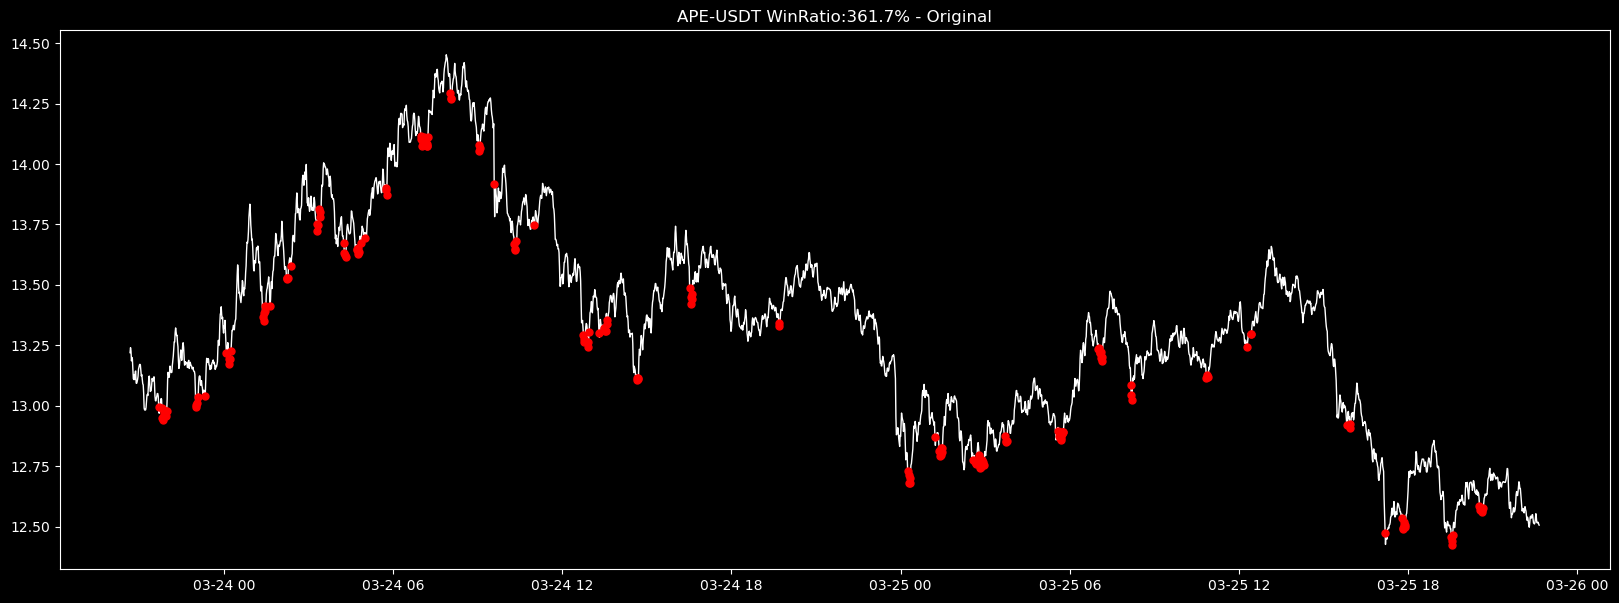

In [14]:
plot_data("Original", pair_to_test, avggg, OnePair_DF, 7000, 3000, OnePair_DF.buy,dot_color="r",fig_width=20, fig_height=7)


In [8]:
pattern = f"*/*Big*"


import os
import glob


path="/UltimeTradingBot/Data"
Model_lists = find_matching_files(path, pattern)
print(Model_lists)
import random
random.shuffle(Model_lists)
print(Model_lists)



['/UltimeTradingBot/Data/IS_CLOSE/tp400_w140_max120min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp170_w40_max40min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp166_w16_max16min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp270_w60_max60min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp310_w40_max40min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp240_w240_max240min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp180_w35_max35min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp133_w33_max33min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_CLOSE/tp130_w25_max25min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_GOOD/tp150_w30_max30min_Model_BigModel_Re1.h5', '/UltimeTradingBot/Data/IS_GOOD/tp150_w30_max30min_Model_BigModel_Re3.h5', '/UltimeTradingBot/Data/IS_GOOD/tp150_w30_max30min_Model_BigModel_Re0.h5', '/UltimeTradingBot/Data/IS_GOOD/tp150_w30_max30min_Model_BigModel_Re2.h5', '/UltimeTradingBot/Data/IS_GOOD/tp150_w30_max30min_Model

In [10]:
import pandas as pd
from pathlib import Path

def append_and_save_results(results_dict, excel_file_path, sheet_name='Sheet1'):
    # Convert the dictionary to a DataFrame
    results_df = pd.DataFrame([results_dict])

    # Check if the Excel file exists
    if Path(excel_file_path).is_file():
        # Read the existing data into a DataFrame
        existing_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
        
        # Append the new results to the existing data
        updated_data = existing_data.append(results_df, ignore_index=True)
        
        # Save the updated data back to the Excel file
        updated_data.to_excel(excel_file_path, sheet_name=sheet_name, index=False)
    else:
        # If the file does not exist, create a new Excel file with the results DataFrame
        results_df.to_excel(excel_file_path, sheet_name=sheet_name, index=False)
    return results_df

# # Example usage
# results_dic = {
#     "key1": "value1",
#     "key2": "value2",
#     "key3": "value3"
# }

# excel_file_path = 'results.xlsx'

# for _ in range(3):  # Replace this loop with your actual loop
#     append_and_save_results(results_dic, excel_file_path)


## Test On special coin

maxi expend : GMT/USDT with those parameters: w1m=6,w5m=10,w15m=50,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
Index(['open', 'high', 'low', 'close', 'high-1', 'low-1', 'close-1',
       'volume-1', 'high-2', 'low-2',
       ...
       'BTC_close-3_5min', 'BTC_volume-3_5min', 'BTC_high-4_5min',
       'BTC_low-4_5min', 'BTC_close-4_5min', 'BTC_volume-4_5min', 'day',
       'hour', 'minute', 'lunch_day'],
      dtype='object', length=504)
Precent Mean: 42.570%
######################  Max Expend GMT/USDT - shape (358605, 499)  buy mean : 42.57 ############################
False
False
Buy mean pct: 42.570%
Precent Mean: 10000.000%


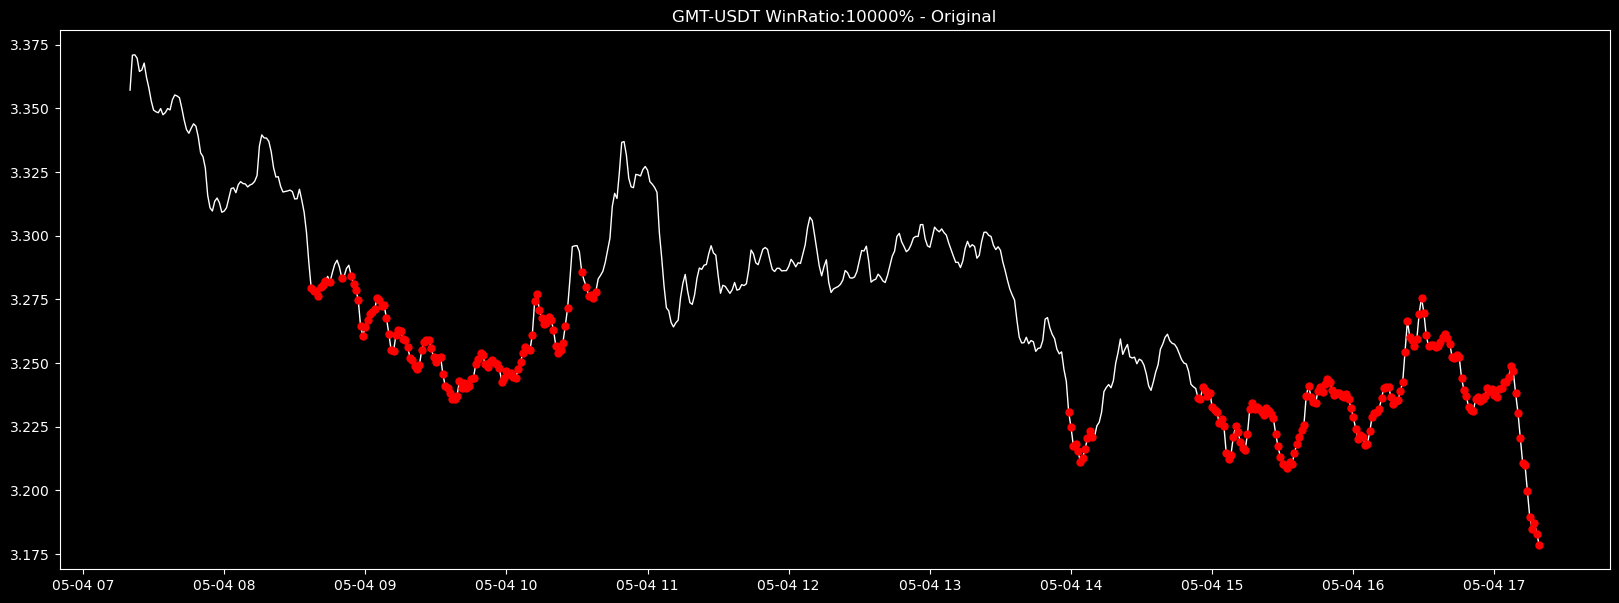

2023-04-30 03:33:42.655632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-30 03:33:42.658215: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-30 03:33:42.658505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: abj-K93SV
2023-04-30 03:33:42.658553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: abj-K93SV
2023-04-30 03:33:42.659408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-04-30 03:33:42.660643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.154.0


11207/11207 [==============================] - 166s 15ms/step
ModelAccuracy: 62.963%
True Win Predictions Mean of all: 7.678%
XXX Loss Buy Mean of all: 2.145%
Missed good deal off all: 34.892%
Good Zero prediction Mean: 55.285%
good fiability
========= Win Ratio:78.16349384098544 %====================
Precent Mean: 78.163%


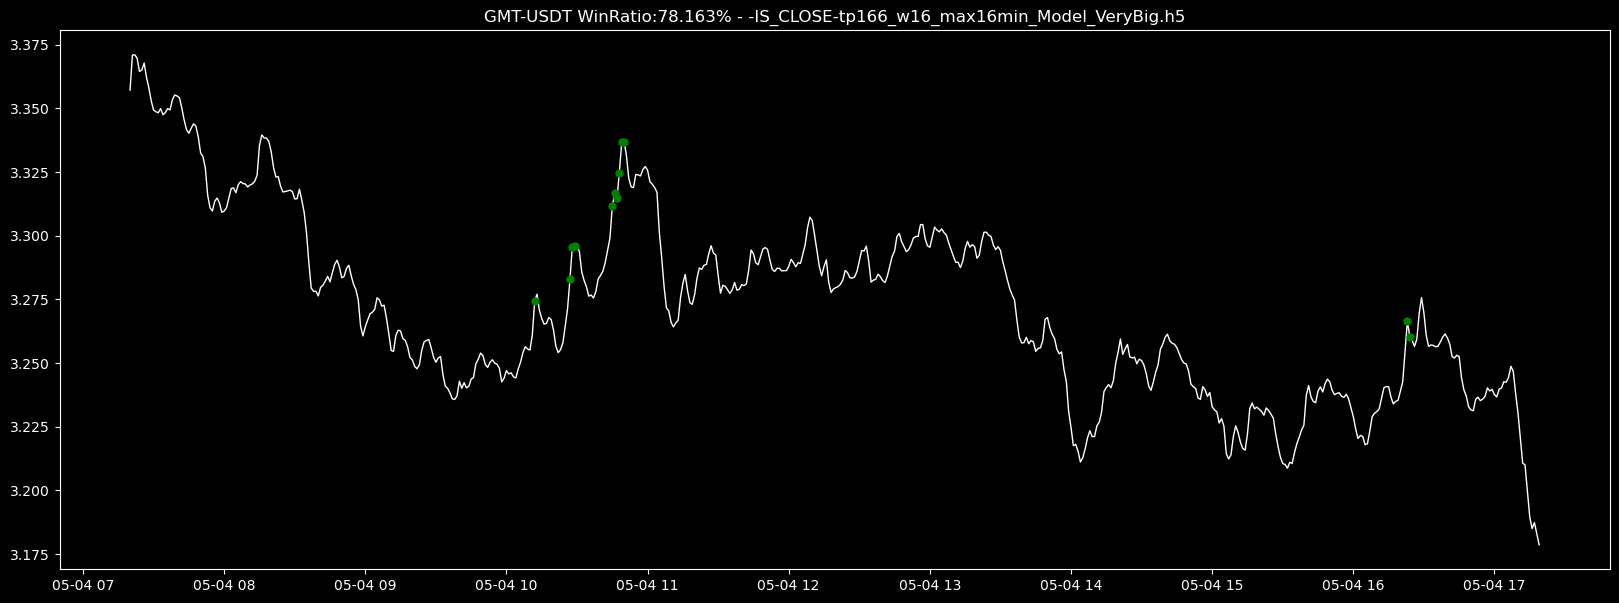

11207/11207 [==============================] - 155s 14ms/step
ModelAccuracy: 57.686%
True Win Predictions Mean of all: 0.270%
XXX Loss Buy Mean of all: 0.015%
Missed good deal off all: 42.300%
Good Zero prediction Mean: 57.416%
check the fiability 100.00099999999999
========= Win Ratio:94.73684210526315 %====================
Precent Mean: 94.737%


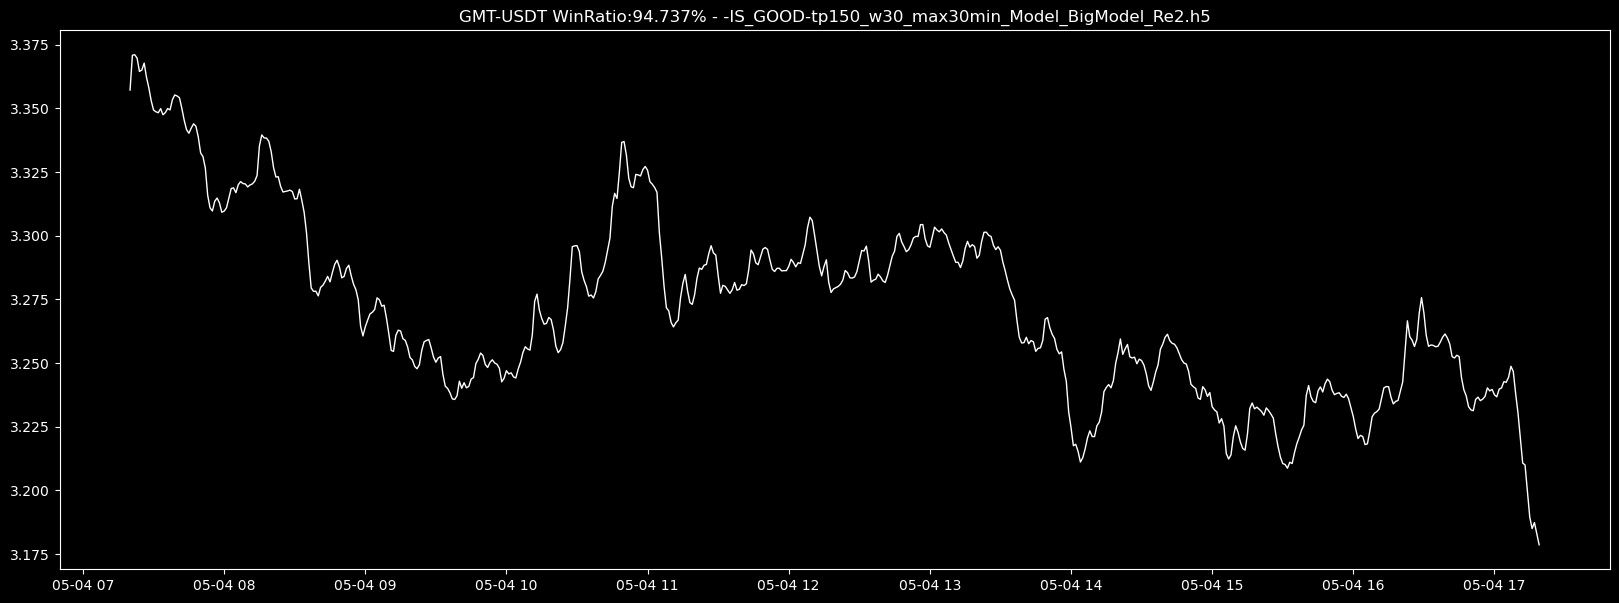

11207/11207 [==============================] - 155s 14ms/step
ModelAccuracy: 57.376%
True Win Predictions Mean of all: 2.310%
XXX Loss Buy Mean of all: 2.364%
Missed good deal off all: 40.259%
Good Zero prediction Mean: 55.066%
check the fiability 99.999
========= Win Ratio:49.42233632862645 %====================
Precent Mean: 49.422%


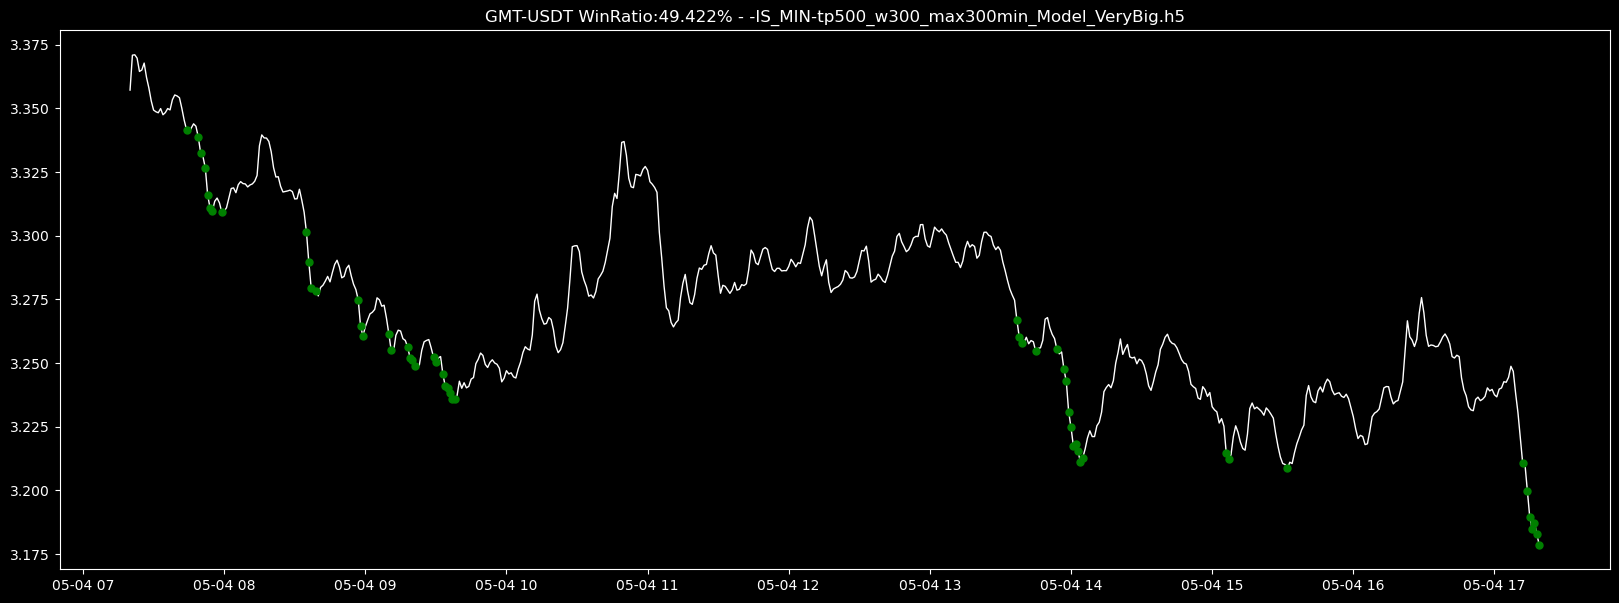

11207/11207 [==============================] - 143s 13ms/step
ModelAccuracy: 61.045%
True Win Predictions Mean of all: 4.268%
XXX Loss Buy Mean of all: 0.653%
Missed good deal off all: 38.302%
Good Zero prediction Mean: 56.777%
good fiability
========= Win Ratio:86.73033936191831 %====================
Precent Mean: 86.730%


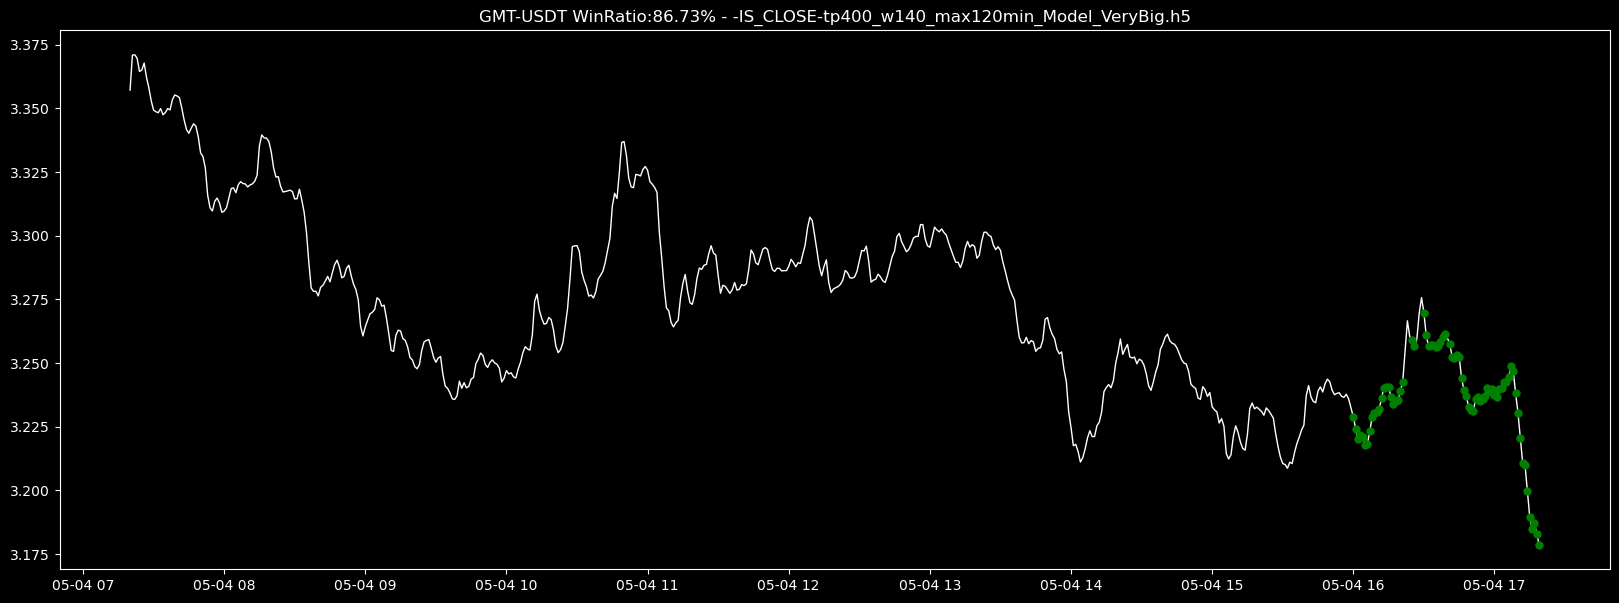

11207/11207 [==============================] - 62s 5ms/step
ModelAccuracy: 57.855%
True Win Predictions Mean of all: 0.465%
XXX Loss Buy Mean of all: 0.040%
Missed good deal off all: 42.105%
Good Zero prediction Mean: 57.390%
good fiability
========= Win Ratio:92.07920792079209 %====================
Precent Mean: 92.079%


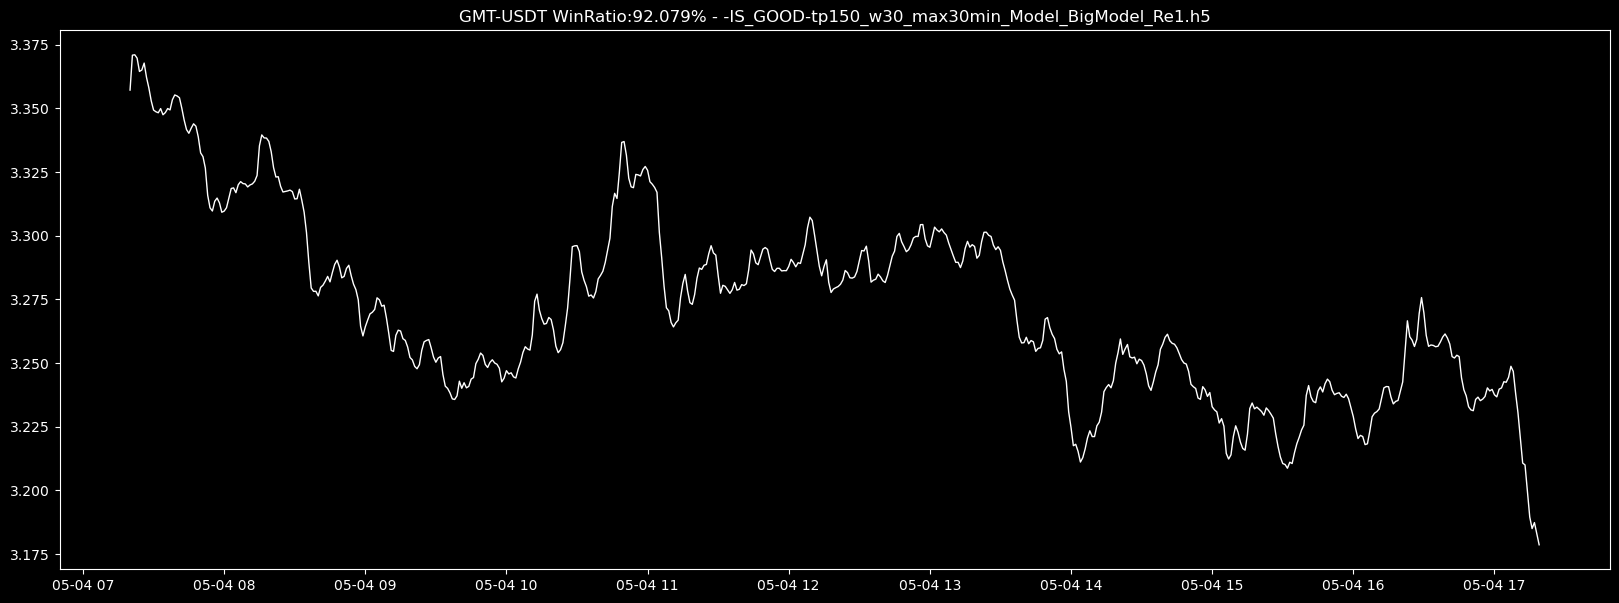

11207/11207 [==============================] - 75s 7ms/step
ModelAccuracy: 61.074%
True Win Predictions Mean of all: 4.955%
XXX Loss Buy Mean of all: 1.311%
Missed good deal off all: 37.615%
Good Zero prediction Mean: 56.119%
good fiability
========= Win Ratio:79.07756144270667 %====================
Precent Mean: 79.078%


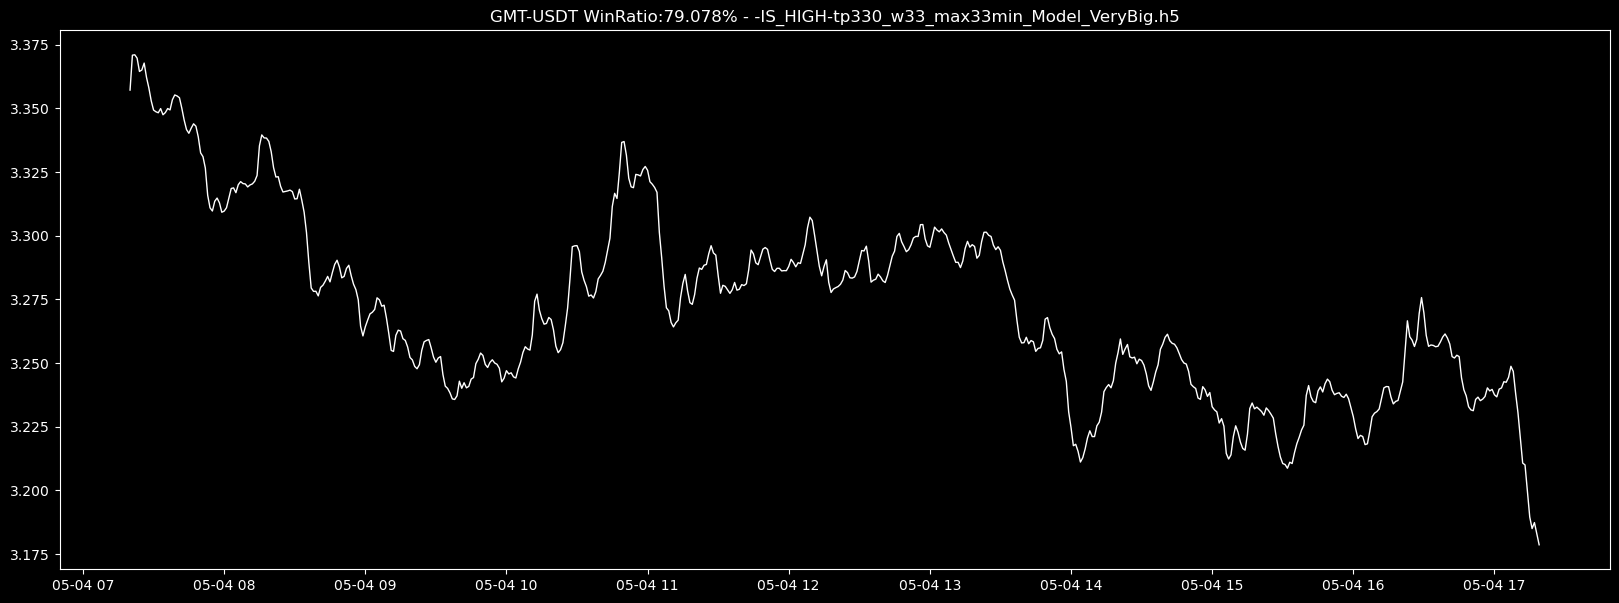

11207/11207 [==============================] - 156s 14ms/step
ModelAccuracy: 60.932%
True Win Predictions Mean of all: 7.729%
XXX Loss Buy Mean of all: 4.228%
Missed good deal off all: 34.841%
Good Zero prediction Mean: 53.203%
check the fiability 100.001
========= Win Ratio:64.63995985615121 %====================
Precent Mean: 64.640%


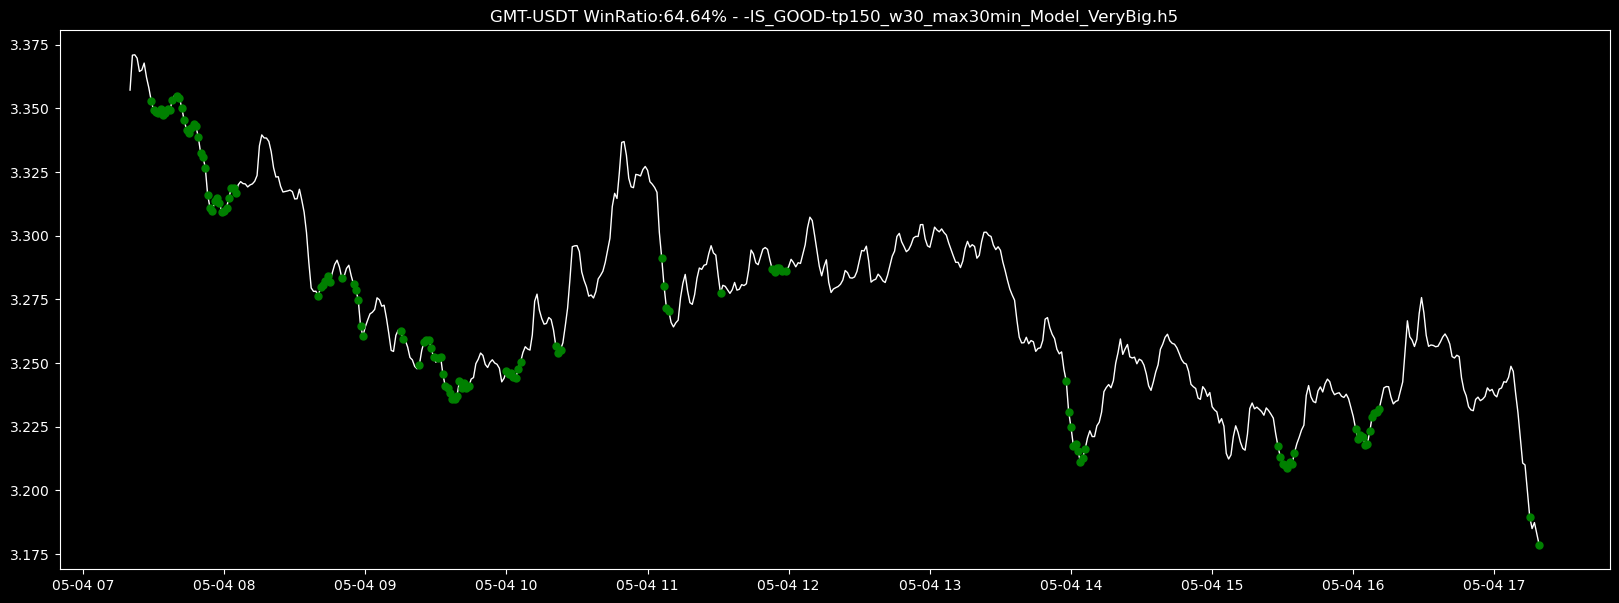

11207/11207 [==============================] - 112s 10ms/step
ModelAccuracy: 64.303%
True Win Predictions Mean of all: 8.434%
XXX Loss Buy Mean of all: 1.561%
Missed good deal off all: 34.135%
Good Zero prediction Mean: 55.869%
check the fiability 99.999
========= Win Ratio:84.38219109554778 %====================
Precent Mean: 84.382%


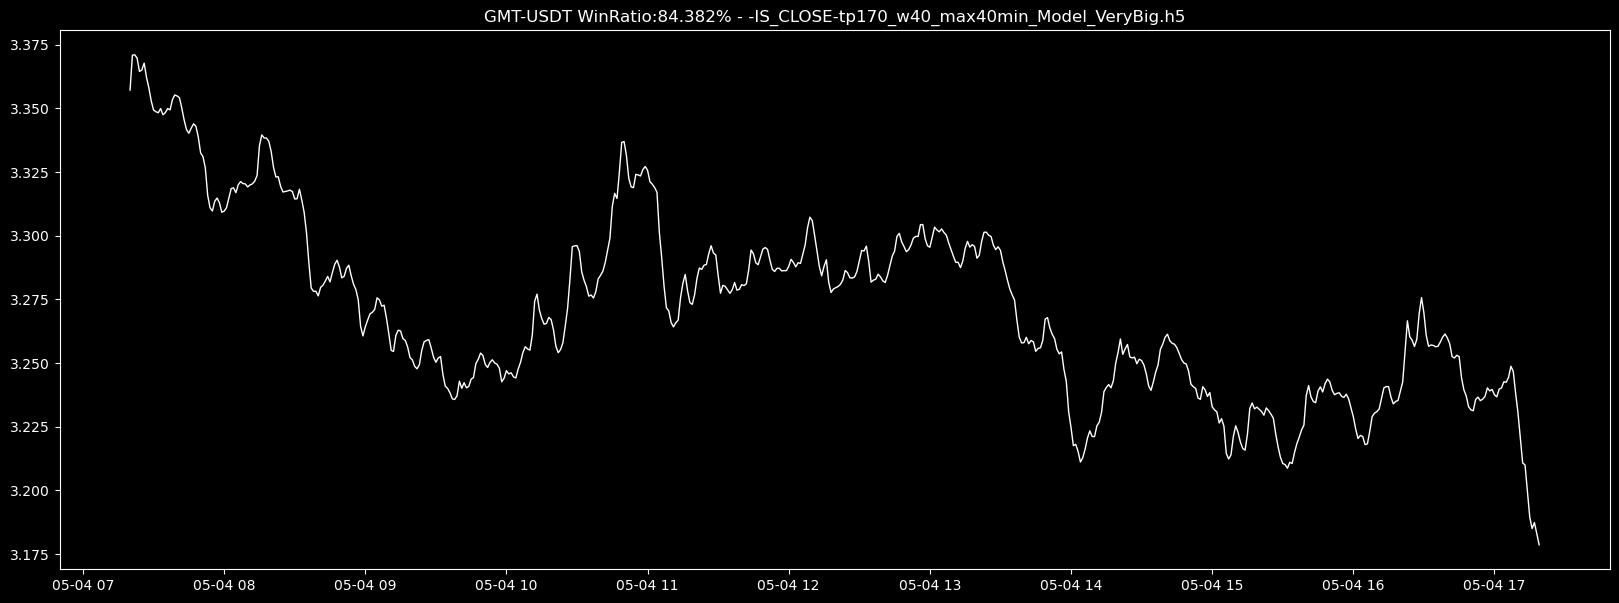

11207/11207 [==============================] - 159s 14ms/step
ModelAccuracy: 64.096%
True Win Predictions Mean of all: 8.434%
XXX Loss Buy Mean of all: 1.769%
Missed good deal off all: 34.136%
Good Zero prediction Mean: 55.662%
check the fiability 100.001
========= Win Ratio:82.6619621679898 %====================
Precent Mean: 82.662%


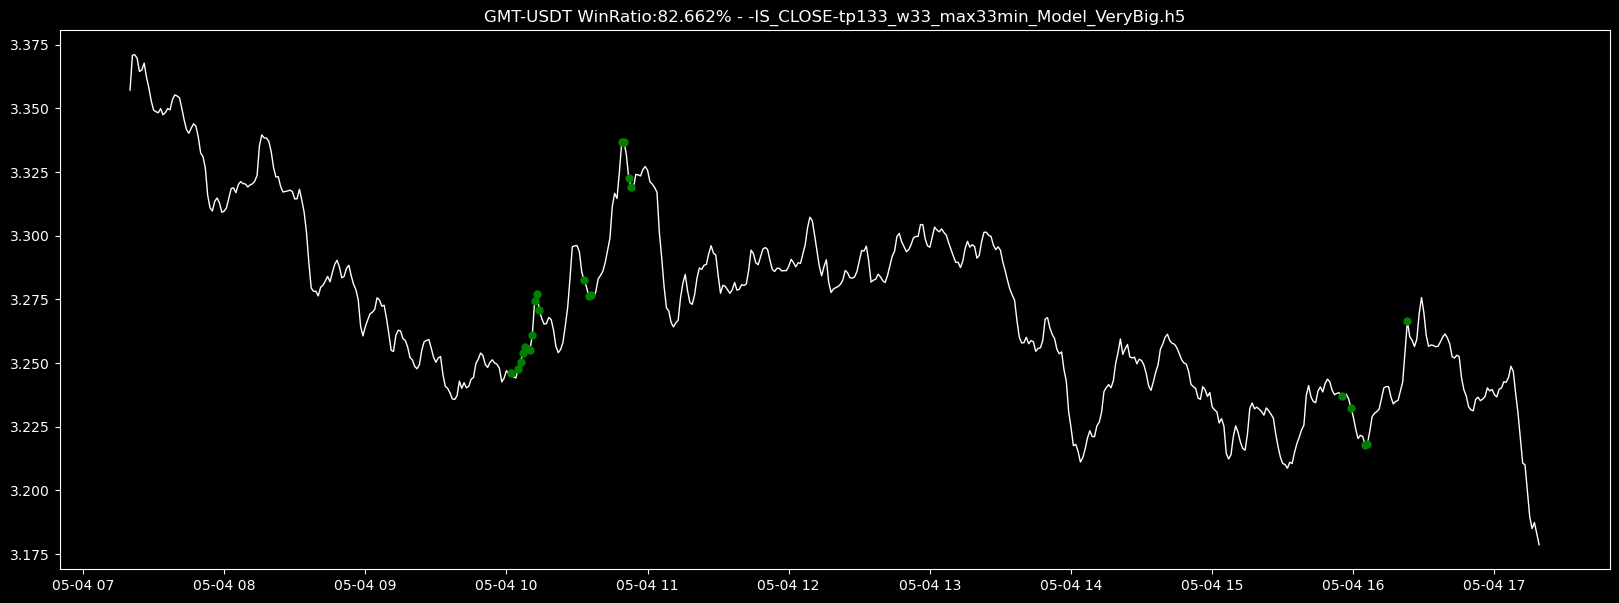

11207/11207 [==============================] - 136s 12ms/step
ModelAccuracy: 57.562%
True Win Predictions Mean of all: 0.137%
XXX Loss Buy Mean of all: 0.005%
Missed good deal off all: 42.432%
Good Zero prediction Mean: 57.425%
check the fiability 99.999
========= Win Ratio:96.47887323943661 %====================
Precent Mean: 96.479%


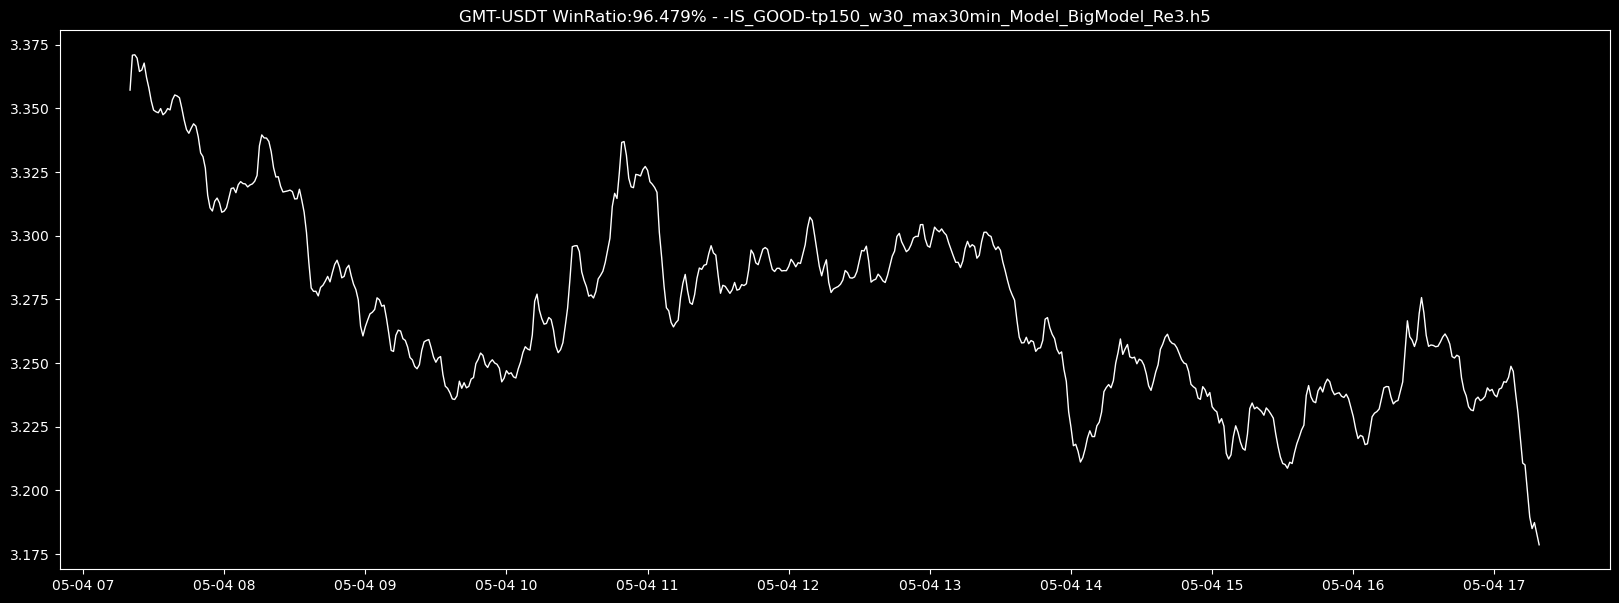

11207/11207 [==============================] - 156s 14ms/step
ModelAccuracy: 61.543%
True Win Predictions Mean of all: 5.208%
XXX Loss Buy Mean of all: 1.095%
Missed good deal off all: 37.362%
Good Zero prediction Mean: 56.336%
check the fiability 100.001
========= Win Ratio:82.62732032365541 %====================
Precent Mean: 82.627%


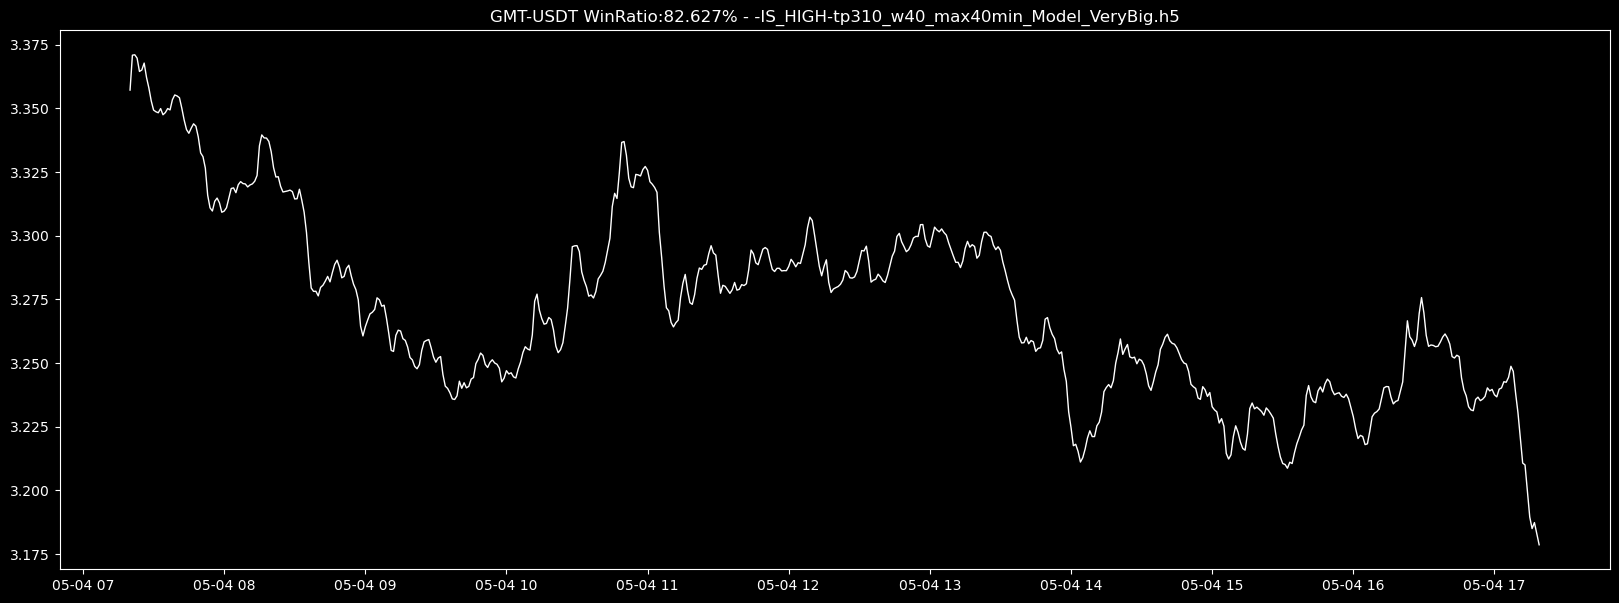

11207/11207 [==============================] - 135s 12ms/step
ModelAccuracy: 58.572%
True Win Predictions Mean of all: 1.362%
XXX Loss Buy Mean of all: 0.220%
Missed good deal off all: 41.208%
Good Zero prediction Mean: 57.210%
good fiability
========= Win Ratio:86.09355246523388 %====================
Precent Mean: 86.094%


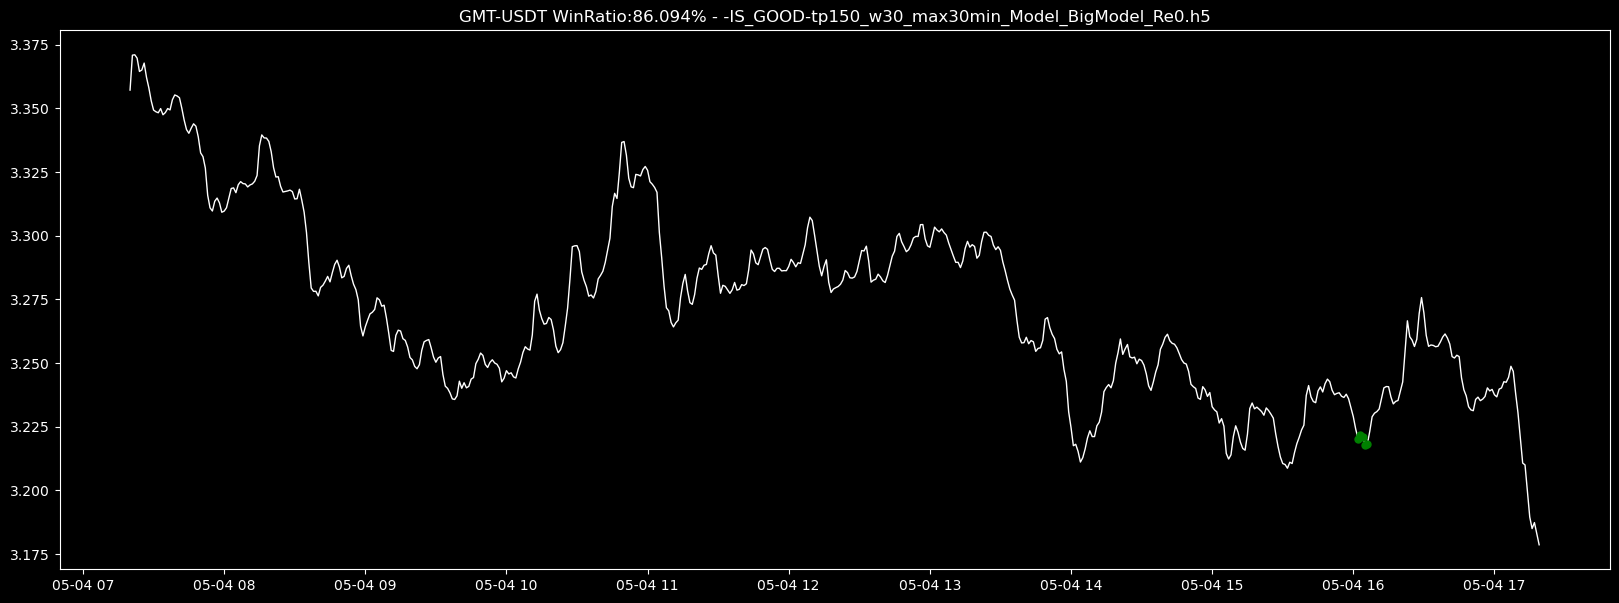

11207/11207 [==============================] - 158s 14ms/step
ModelAccuracy: 62.437%
True Win Predictions Mean of all: 6.016%
XXX Loss Buy Mean of all: 1.009%
Missed good deal off all: 36.554%
Good Zero prediction Mean: 56.421%
good fiability
========= Win Ratio:85.63701067615658 %====================
Precent Mean: 85.637%


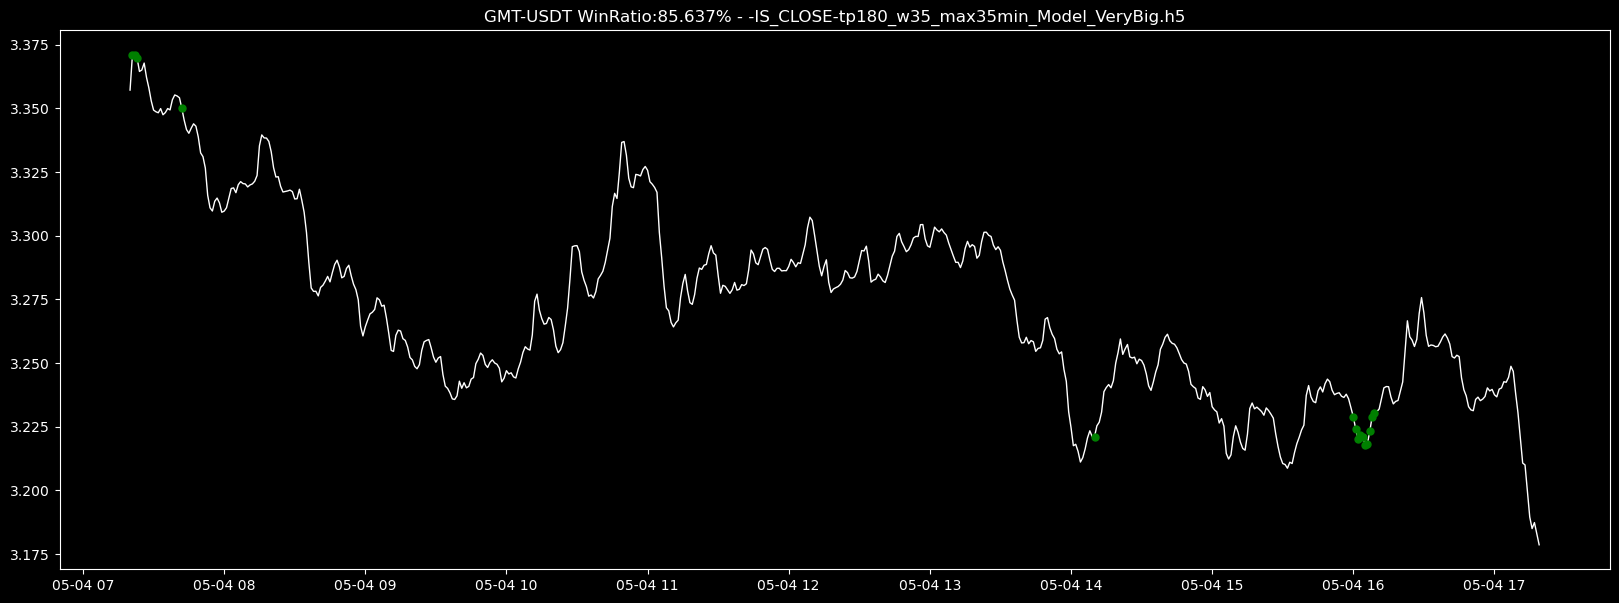

11207/11207 [==============================] - 154s 14ms/step
ModelAccuracy: 64.518%
True Win Predictions Mean of all: 9.367%
XXX Loss Buy Mean of all: 2.279%
Missed good deal off all: 33.203%
Good Zero prediction Mean: 55.151%
good fiability
========= Win Ratio:80.43104928730895 %====================
Precent Mean: 80.431%


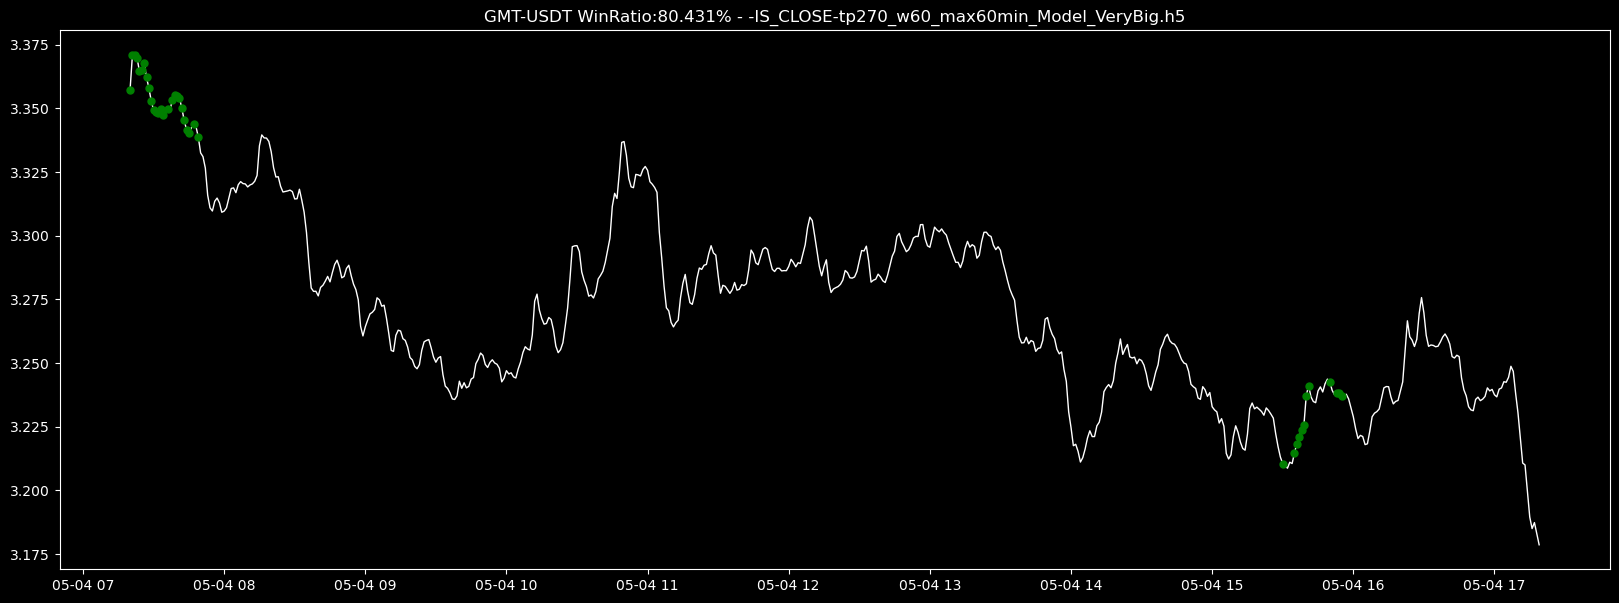

11207/11207 [==============================] - 157s 14ms/step
ModelAccuracy: 65.076%
True Win Predictions Mean of all: 10.352%
XXX Loss Buy Mean of all: 2.707%
Missed good deal off all: 32.218%
Good Zero prediction Mean: 54.724%
check the fiability 100.001
========= Win Ratio:79.27100084233095 %====================
Precent Mean: 79.271%


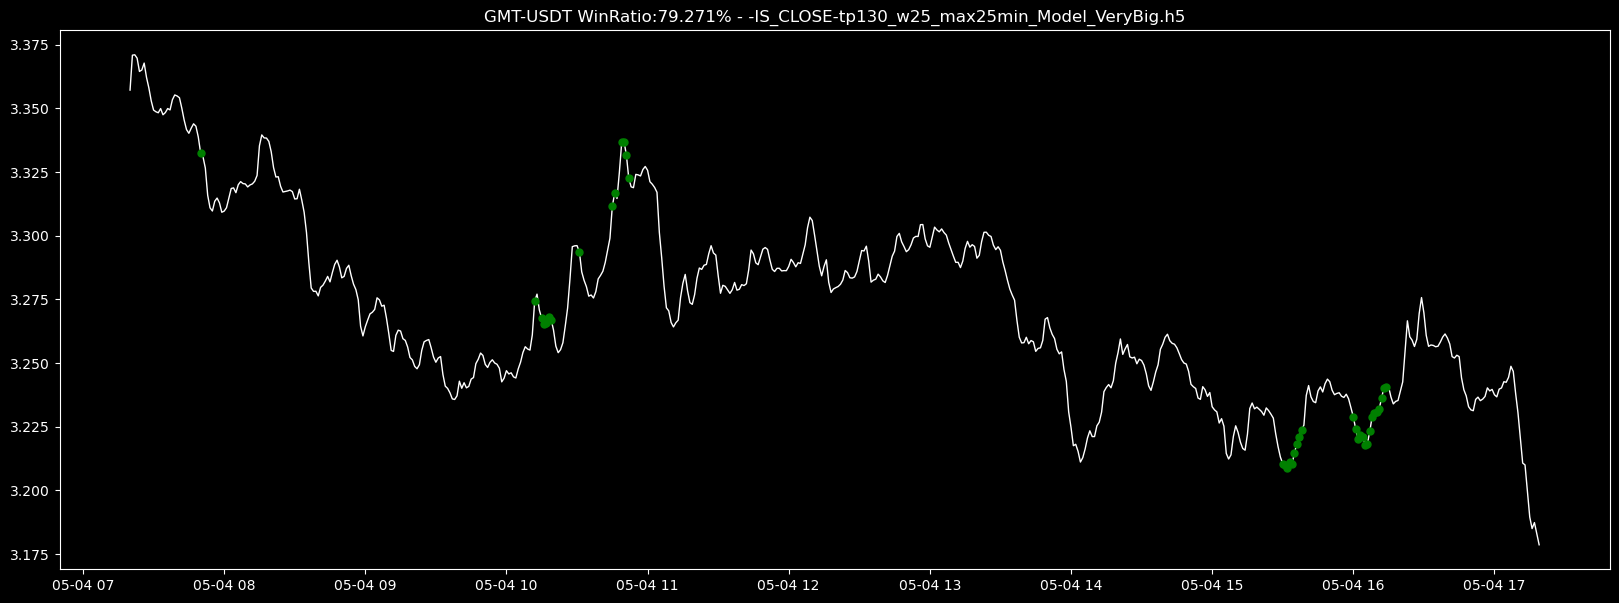

11207/11207 [==============================] - 154s 14ms/step
ModelAccuracy: 62.713%
True Win Predictions Mean of all: 6.608%
XXX Loss Buy Mean of all: 1.326%
Missed good deal off all: 35.961%
Good Zero prediction Mean: 56.105%
good fiability
========= Win Ratio:83.28711872951853 %====================
Precent Mean: 83.287%


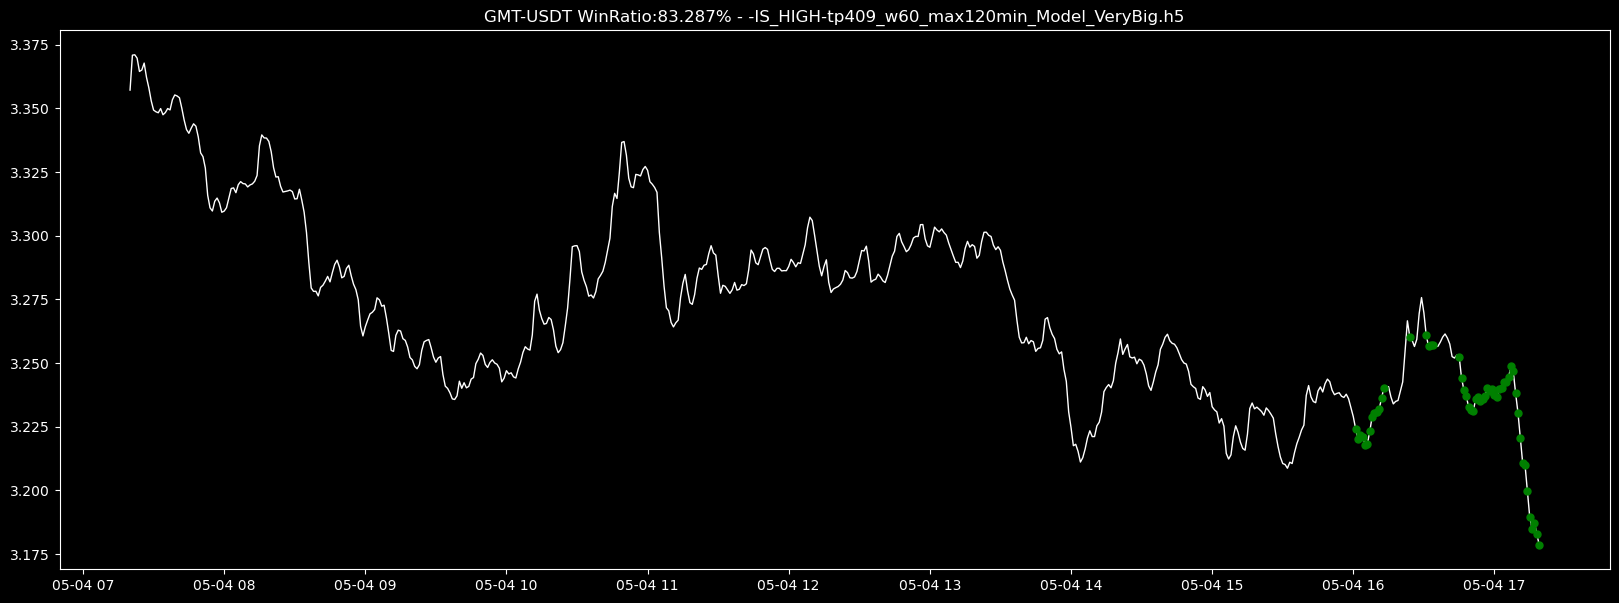

11207/11207 [==============================] - 154s 14ms/step
ModelAccuracy: 67.474%
True Win Predictions Mean of all: 10.859%
XXX Loss Buy Mean of all: 0.815%
Missed good deal off all: 31.711%
Good Zero prediction Mean: 56.615%
good fiability
========= Win Ratio:93.01867397635772 %====================
Precent Mean: 93.019%


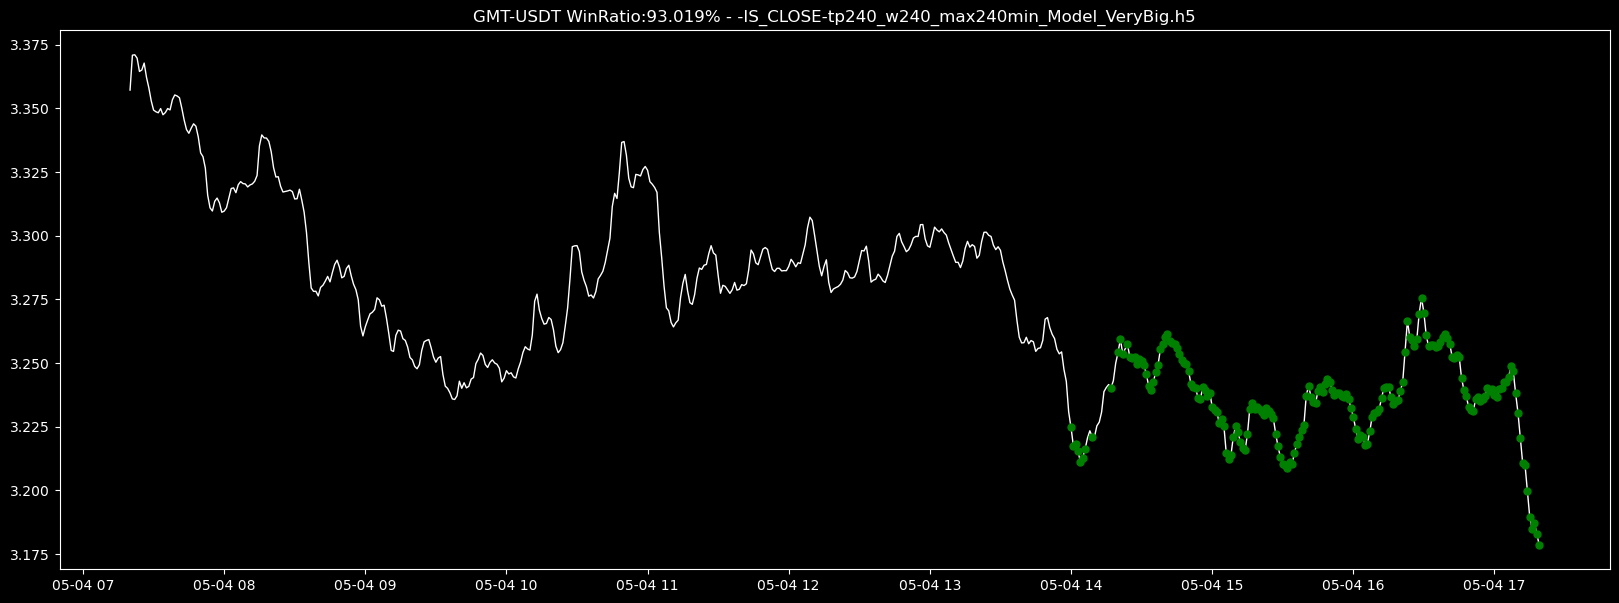

11207/11207 [==============================] - 113s 10ms/step
ModelAccuracy: 62.897%
True Win Predictions Mean of all: 7.248%
XXX Loss Buy Mean of all: 1.782%
Missed good deal off all: 35.322%
Good Zero prediction Mean: 55.649%
check the fiability 100.001
========= Win Ratio:80.265780730897 %====================
Precent Mean: 80.266%


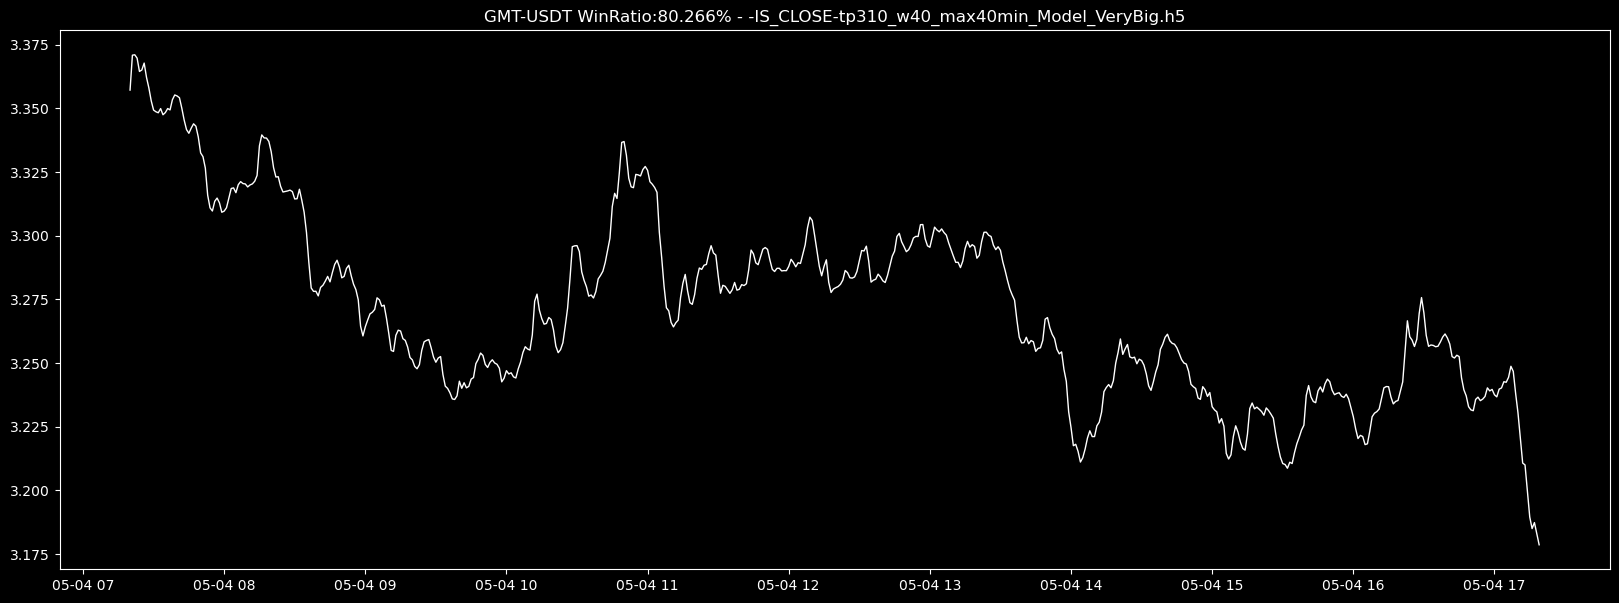

In [9]:
## Generate Data
excel_file_path = 'workdir/normaltests/results.xlsx'
Mlist=Model_lists
# MAX_FORCAST_SIZE=40
# Mlist=[              f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re2.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re4.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re5.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re6.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re7.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re8.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re9.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryBig.h5",
    
#                         ]

# Mlist=[              
#                        '/UltimeTradingBot/Data/IS_CLOSE/TP270.0_MHT240min_Model_Re0.h5',
#                        '/UltimeTradingBot/Data/IS_CLOSE/TP270.0_MHT240min_Model_Re2.h5',
#                        '/UltimeTradingBot/Data/IS_CLOSE/TP270.0_MHT240min_Model_Re4.h5',
#                         '/UltimeTradingBot/Data/IS_CLOSE/TP270.0_MHT240min_Model_Re1.h5',
#                         '/UltimeTradingBot/Data/IS_CLOSE/TP270.0_MHT240min_Model_Re3.h5',
#                                                 ]
TEST_RES01=pd.DataFrame()

BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
pair_to_test="GMT/USDT"
MAX_FORCAST_SIZE=120

BUY_PCT_TEST=1.9
loc_start=0
loc_end=1000000


i_start=71000
i_end=i_start+200

# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))

pair=pair_to_test
OnePair_DF=maxi_expand(pair=pair,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=BUY_PCT_TEST,SELL_PCT=SELL_PCT,buy_function=is_high_win,
                           w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)



OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
hp(OnePair_DF.buy.mean(),"Buy mean pct")



plot_data("Original", pair_to_test, 100, OnePair_DF, i_start, 600, OnePair_DF.buy,dot_color="r",fig_width=20, fig_height=7)
results_df=pd.DataFrame()
for Model_FileName in Mlist:

    try:
        USED_MODEL=load_model(Model_FileName)


        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        OnePair_Pred=OnePair_PredNote.round()

        gc.collect()

        Original_Traget_Data=OnePair_DT[:,-1]
        Predicted_Data=OnePair_Pred[:,0]
        gc.collect()
        TruePred=(Original_Traget_Data==Predicted_Data).copy()
        ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
        gc.collect()
        TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
        TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
        gc.collect()
        LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
        LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
        gc.collect()

        MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
        MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
        gc.collect()

        GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
        GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
        gc.collect()

        fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
        if( fiability == 100):print("good fiability")
        else: print(f"check the fiability {fiability}")
        winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

        print(f"========= Win Ratio:{winratio*100} %====================")
        TEST_ISTANT_DIC={
                    "Model_FileName":Model_FileName,
                    "winratio":winratio,
                    "ModelAccuracy":ModelAccuracy,
                    "TrueWinPred_Mean":TrueWinPred_Mean,
                    "TEST_RES01":TEST_RES01,
                    "BAD_PERIOD_END":BAD_PERIOD_END,
                    "pair_to_test":pair_to_test,
                    "MAX_FORCAST_SIZE":MAX_FORCAST_SIZE,
                    "BUY_PCT_TEST":BUY_PCT_TEST
                    }
        #results_df = results_df.append(TEST_ISTANT_DIC, ignore_index=True)
        results_df=append_and_save_results(TEST_ISTANT_DIC, excel_file_path, sheet_name='NormalTest01')



        PREDICTION_TO_TEST=Predicted_Data



        plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 600, PREDICTION_TO_TEST,dot_color="g",fig_width=20, fig_height=7)
    except:
        print(f"error in plotting:{Model_FileName}")

In [73]:
RRx=results_df[results_df["TrueWinPred_Mean"]>2].sort_values("winratio",ascending=False)
RRx

,Model_FileName,winratio,ModelAccuracy,TrueWinPred_Mean,TEST_RES01,BAD_PERIOD_END,pair_to_test,MAX_FORCAST_SIZE,BUY_PCT_TEST


In [53]:
Model_Best_X=list(RRx["Model_FileName"][:])
Model_Best_X

['/UltimeTradingBot/Data/IS_CLOSE/tp240_w240_max240min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp400_w140_max120min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp180_w35_max35min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp170_w40_max40min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp133_w33_max33min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_HIGH/tp310_w40_max40min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp270_w60_max60min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp310_w40_max40min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp130_w25_max25min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_HIGH/tp330_w33_max33min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_CLOSE/tp166_w16_max16min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_GOOD/tp150_w30_max30min_Model_VeryBig.h5']

In [74]:
Model_Best_X=['/UltimeTradingBot/Data/IS_CLOSE/tp400_w140_max120min_Model_VeryBig.h5',
 '/UltimeTradingBot/Data/IS_GOOD/tp150_w30_max30min_Model_VeryBig.h5']

In [75]:
import numpy as np
from tensorflow.keras.models import load_model

def load_models(model_files):
    """
    Load Keras models from a list of .h5 files.

    Args:
        model_files (list): A list of .h5 file paths containing Keras models.

    Returns:
        list: A list of loaded Keras models.
    """
    return [load_model(model_file) for model_file in model_files]

def predict_multi(models, input_data):
    """
    Make predictions using a list of Keras binary classification models with the same input shape.

    Args:
        models (list): A list of Keras models.
        input_data (list or np.array): Input data for making predictions.

    Returns:
        np.array: Predicted class labels with the highest ensemble probability.
    """
    # Ensure input data is a NumPy array
    input_data = np.array(input_data)
    
    # Make predictions using each model
    predictions = [model.predict(input_data) for model in models]

    # Average the predictions to get an ensemble prediction
    ensemble_prediction = np.mean(predictions, axis=0)

    # Return the class with the highest ensemble probability
    return ensemble_prediction#np.argmax(ensemble_prediction, axis=1)

# Example usage
model_files = Model_Best_X
models = load_models(model_files)
input_data = OnePair_DT[:, 0:-1] #[[0.1, 0.5, 0.3, 0.9], [0.6, 0.4, 0.7, 0.2]]  # Replace with your input data
best_predictions = predict_multi(models, input_data)
print(best_predictions)


11207/11207 [==============================] - 363s 32ms/step
[[0.6343888 ]
 [0.6948393 ]
 [0.58512026]
 ...
 [0.26076072]
 [0.35707563]
 [0.26282737]]


In [55]:
best_predictions[:,-1]


array([0.70243615, 0.68176425, 0.6614361 , ..., 0.14626452, 0.1606243 ,
       0.13920335], dtype=float32)

ModelAccuracy: 59.359%
True Win Predictions Mean of all: 2.010%
XXX Loss Buy Mean of all: 0.081%
Missed good deal off all: 40.559%
Good Zero prediction Mean: 57.349%
check the fiability 99.999
========= Win Ratio:96.12625538020086 %====================
Precent Mean: 96.126%


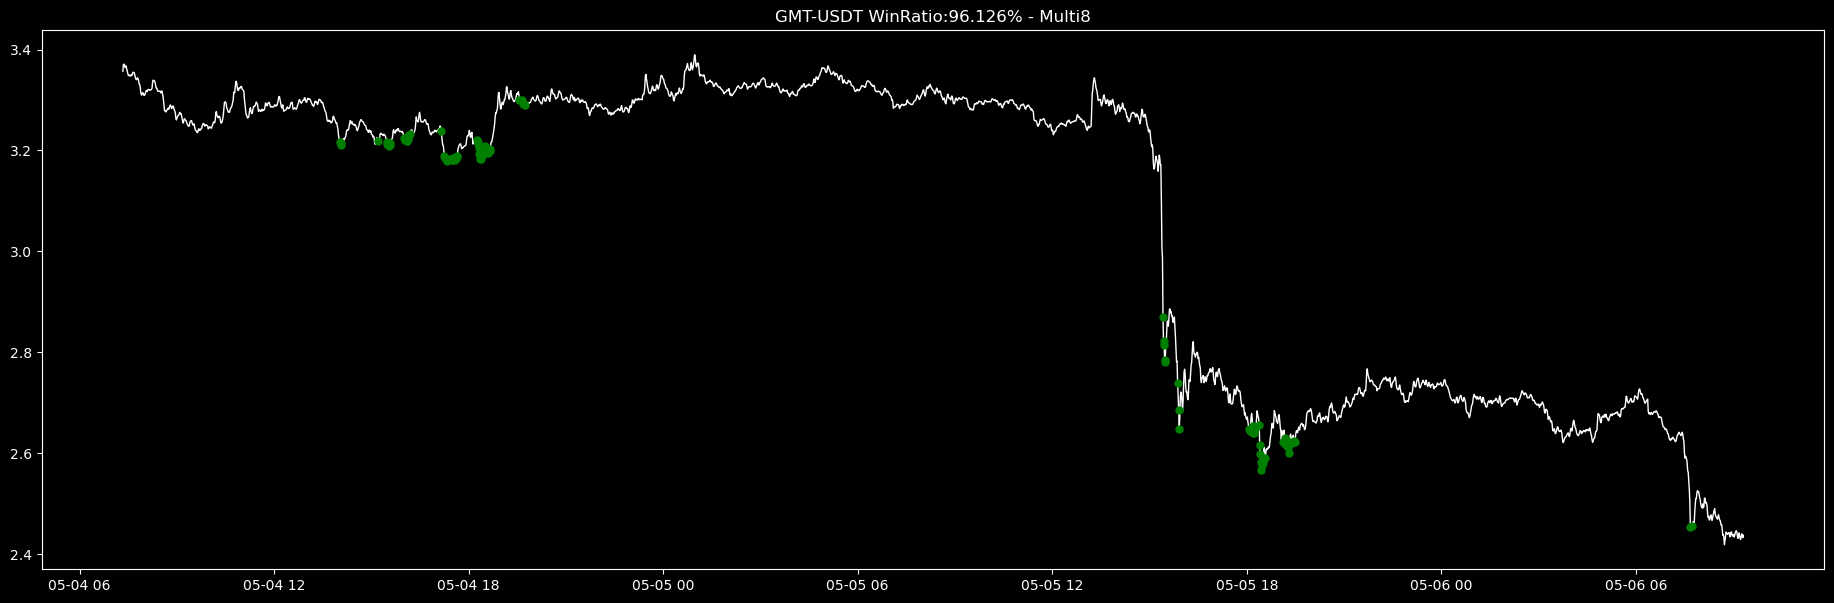

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [83]:
excel_file_path = 'workdir/normaltests/results.xlsx'
results_df=pd.DataFrame()
Model_FileName=f"Multi8"
PRECISION=-0.2
OnePair_Pred=(best_predictions[:,-1]+PRECISION).round()

gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
Predicted_Data=OnePair_Pred
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")
TEST_ISTANT_DIC={
            "Model_FileName":Model_FileName,
            "winratio":winratio,
            "ModelAccuracy":ModelAccuracy,
            "TrueWinPred_Mean":TrueWinPred_Mean,
            "TEST_RES01":TEST_RES01,
            "BAD_PERIOD_END":BAD_PERIOD_END,
            "pair_to_test":pair_to_test,
            "MAX_FORCAST_SIZE":MAX_FORCAST_SIZE,
            "BUY_PCT_TEST":BUY_PCT_TEST
            }
results_df = results_df.append(TEST_ISTANT_DIC, ignore_index=True)



PREDICTION_TO_TEST=Predicted_Data



plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 3000, PREDICTION_TO_TEST,dot_color="g",fig_width=23, fig_height=7)
results_df=append_and_save_results(TEST_ISTANT_DIC, excel_file_path, sheet_name='Multimodel02')



Precent Mean: 96.126%


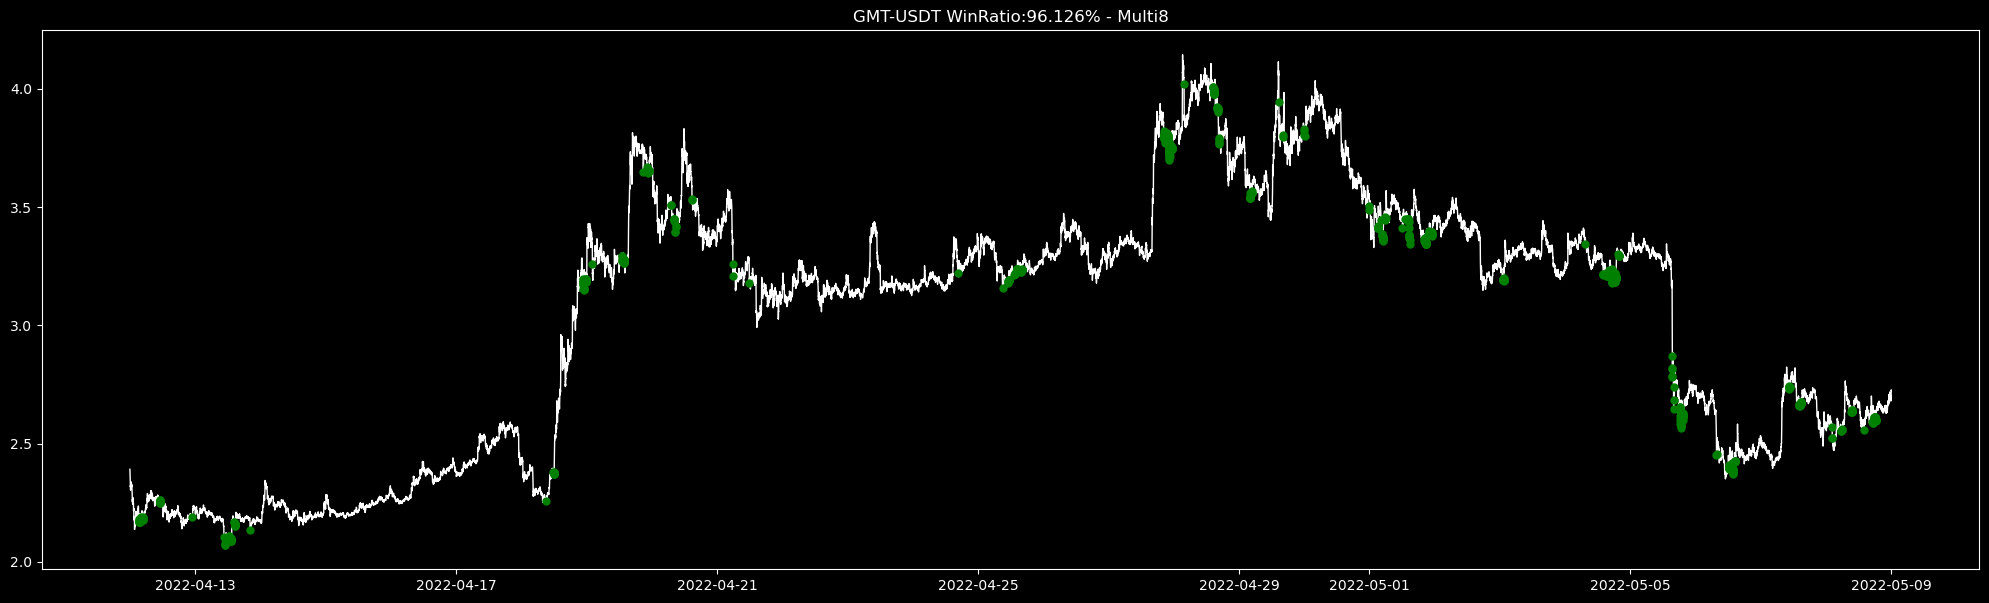

In [87]:
double_days=1440*27
start_point=double_days*1
plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, start_point, double_days, PREDICTION_TO_TEST,dot_color="g",fig_width=25, fig_height=7)
